In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('data/round_train.csv')

In [4]:
data = data[data.Tournament_Year.isin(range(2003,2007))]

In [5]:
data.shape

(76789, 12)

In [6]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [7]:
def label_players(player_inds,players):
    groups_d = {}
    for player in players:
        if sum(player not in player_ind for player_ind in player_inds)==5:
            probs = np.array([1/float(len(player_ind))**3 if len(player_ind)!=0 else 1 for player_ind in player_inds])
            #print p,p.sum()
            probs = probs/float(probs.sum())
            g = np.random.choice(range(5),1,p=probs)[0]
            player_inds[g][player] = len(player_inds[g])
            groups_d[player] = g
    indexes = []
    groups = []
    for player in players:
        indexes.append(player_inds[groups_d[player]][player])
        groups.append(groups_d[player])
    return (player_inds,indexes,groups)

In [8]:
player_inds = [{} for _ in range(5)]
player_inds,indexes,groups = label_players(player_inds,data.Player_Number.values)
player_inds_reverse = [dict((v, k) for k, v in player_ind.iteritems()) for player_ind in player_inds]

In [9]:
data.insert(5,'Group_Number',groups)
data.insert(6,'Index_Number',indexes)

In [10]:
rounds = data.groupby(['Tournament_Year','Tournament_#','Round_Number'])

In [11]:
len(rounds)

738

In [12]:
len(pd.unique(data.Player_Number))

1316

In [14]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  opt = np.get_printoptions()
  np.set_printoptions(threshold='nan')
  pprint(*args, **kwargs)
  np.set_printoptions(**opt)

In [15]:
n_players = [len(pd.unique(data[data.Group_Number == n].Player_Number)) for n in range(5)]
n_rounds = len(rounds)

In [16]:
n_players

[253, 264, 268, 269, 262]

In [85]:
BETA = 1
A = [np.zeros((n*20,n*20)) for n in n_players]
G = [np.zeros((n,20)) for n in n_players]
for u,df in enumerate(rounds):
    if u>=80:
        continue
    df = df[1]
    df = df.sort_values('Round_Score')
    not_this_period = filter(lambda x: x!=u/20,range(20))
    for g in range(5):
        df_g = df[df.Group_Number==g]
        n = len(df_g)
        if n==1:
            continue
        G[g][df_g.Index_Number,u/20] += 1
        for u1,p_id in enumerate(df_g.Index_Number):
            arr = np.zeros(n_players[g])
            if u1!=n-1:
                arr[df_g.Index_Number[u1+1:].values] = 1
            A[g][u/20*n_players[g] + p_id,u/20*n_players[g]:(u/20+1)*n_players[g]] += arr / n
            A[g][[u2*n_players[g] + p_id for u2 in not_this_period],u/20*n_players[g]:(u/20+1)*n_players[g]] += \
                np.matrix(map(lambda x: BETA**abs(x-u/20),not_this_period)) * \
                np.array([arr / n for _ in range(19)])
            #weights = np.matrix(G[g][p_id,:] / G[g].sum(1)[p_id])

In [33]:
(A[g][p_id,:,:]>0)
np.transpose(G[g][p_id,:] / G[g].sum(1)[p_id]).shape

(529,)

In [95]:
A[g].sum(1)[0],A[g].sum(1)[n_players[g]*8]

(307.28942423755512, 475.50939886562566)

In [51]:
n_players[g]

262

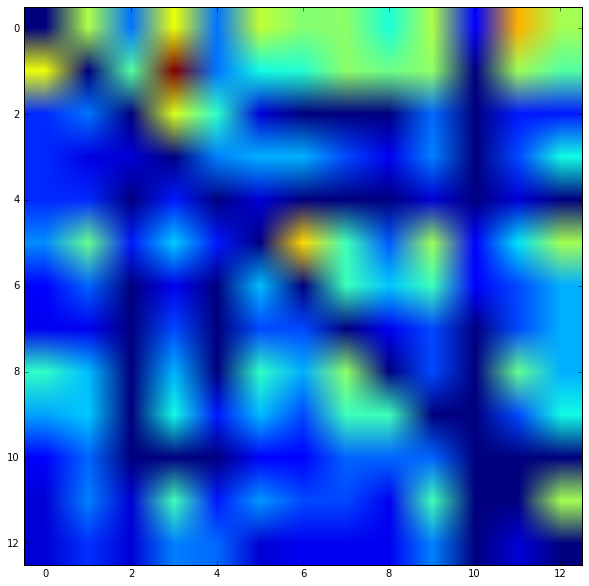

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
#plt.imshow(G[g])
plt.imshow(A[g][2*n:3*n,2*n:3*n])
plt.show()

In [287]:
for g in range(5):
    print 'Group %d\n' % (g+1,)
    p_nums = V[g].sum(1).argsort().tolist()[::-1][:20]
    for u,p in enumerate(p_nums):
        if G[g].sum(1)[p] > 6:
            print p,data[(data.Player_Number==player_inds_reverse[g][p])].iloc[0].Player_Name,
            print np.sort(V[g].sum(1)).tolist()[::-1][u], G[g].sum(1)[p]
    if g!=4: print '\n****************\n'

Group 1

66 Heintz, Bob 1.02426226411 12.0
19 Donald, Luke 1.02351409601 197.0
61 McIlroy, Rory 1.02195425987 140.0
138 Edfors, Johan 1.02110172624 8.0
2 Kuchar, Matt 1.02036304931 263.0
16 Rose, Justin 1.01594445364 223.0
169 Blixt, Jonas 1.01338581116 72.0
3 Johnson, Zach 1.01264621541 263.0
71 Oosthuizen, Louis 1.01194788758 116.0
40 Mahan, Hunter 1.01172781273 255.0
8 Toms, David 1.01146848857 219.0
22 Dufner, Jason 1.01100010952 247.0
41 Holmes, J.B. 1.01030164782 238.0

****************

Group 2

0 Stricker, Steve 1.02594660678 209.0
29 Day, Jason 1.01718590889 209.0
61 Kaymer, Martin 1.01616745266 86.0
6 Moore, Ryan 1.01583810048 242.0
17 de Jonge, Brendon 1.01571902525 334.0
18 Choi, K.J. 1.01514716001 227.0
79 Cauley, Bud 1.01510250808 131.0
62 McDowell, Graeme 1.01480938606 131.0
85 Noh, Seung-Yul 1.01349171556 133.0
65 Duke, Ken 1.01214407693 120.0
16 Palmer, Ryan 1.00976538181 245.0
60 Poulter, Ian 1.0097116618 153.0
39 Hoffman, Charley 1.0082432869 262.0
33 Elkington, Stev